#

<center> <h1 style='font-size:45px; text-align:center; font-weight:900'>Indian Sign Language Classification using Transfer Learning</h1> </center>

#

![Indian Sign Language](https://vajiramandravi.s3.us-east-1.amazonaws.com/media/2019/2/28/16/52/7/isl.jpg)

#####

# Introduction

* The basic requirement of the peoples are the communication which allows everyone to share their thoughts and emotion with some other persons, without communication we all will be stressed out and it is really a tough situation to live.
* There exists two main languages as **Speech Language** and **Sign Language**. The speech language is for the peoples who can talk and hear the voices around them whereas the sign language is for the people who can't hear or speak.
* Due to this reason there will be a communication barrier between the sign language peoples and the normal leanguage people as the learning of sign language is really a hard work to do with.
* The main objective of this project is to provide an efficient way to build a model which is to be used to interprets the sign language into speech language.
* This model is build on the **Xception architecture** which is better than the VGG-16, ResNet-152, Inception V3 models.

# Objective

* To train CNN model which is capable of classifying the alpha numeric hand gestures of Indian Sign Language.
* To improve the accuracy by using transfer learning technique.

**Sign language is one of the toughest language compared to the speech language so it isnot possible to learn this, so to overcome this situation a modern technical solution is required this problem.   And this application is required for:**

* **Promotion:** This interpreter equal access to information, services, and opportunities to the sign language people

* **Better Environment:** Fosters inclusivity and diversity for the sign language people so that they wont hesitate to comminicate with the other people.

* **Relationships:** This interpreter Strengthens relationships between deaf and hearing individuals and communities.

As the world continues to recognize the importance of sign language, it is essential to continue promoting and supporting its use and growth. By utilizing this application, we can create a more inclusive and accessible society for all the people including the sign language and the speech language people.

### Importing the required libraries

In [1]:
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import cv2 as cv
import os

### Enabling GPU for higher performance

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Initializing the common variables and functions

In [3]:
# Used to resize the image to 224 x 224 size (resolution)

def read_image(path, images, labels, filenames):
    
    for root, dirs, files in os.walk(path):

        for name in dirs:
            
            direct = os.path.join(path, name)
            
            for filename in os.listdir(direct):
                
                img = cv.imread(os.path.join(path + "/" + name, filename))
                labels.append(name)
                img = cv.resize(img, Image_Size)
                images.append(img)
                filenames.append(name + '/' + filename)

In [4]:
# Function to create dataframe from the filenames and labels

def create_dataframe(filenames, labels):
    
    df = pd.DataFrame({
        
    'filename' : filenames,
    'category' : labels

    })
    
    return df

In [5]:
# Defining the common variables

Image_Width=250
Image_Height=250
Image_Size=(Image_Width,Image_Height)
Image_Channels=3
batch_size = 32

In [6]:
# Initializing train variables

filenames = []
images = []
labels = []
path = './original_images/'

# Invoking read_image() in order to read the images from the path and to store in the above initialized array

read_image(path=path, filenames=filenames, images=images, labels=labels)

In [7]:
# Train dataframe made from create_dataframe()

df = create_dataframe(filenames=filenames, labels=labels)
df

,filename,category
0,0/1.jpg,0
1,0/10.jpg,0
2,0/100.jpg,0
3,0/1000.jpg,0
4,0/101.jpg,0
...,...,...
35995,Z/995.jpg,Z
35996,Z/996.jpg,Z
35997,Z/997.jpg,Z
35998,Z/998.jpg,Z


### Spliting the dataset for train and test

In [8]:
# Spliting the dataset into train_df and test_df with test size of 0.1

train_df, test_df =  train_test_split(df, test_size=0.1, random_state=53, stratify=df['category'])

In [9]:
#preprocessing train data

train_datag=ImageDataGenerator(rescale=1./ 255, # converting the pixels of image between o's and 1's
                              horizontal_flip = True, # flipping the image horizontally
                               vertical_flip = True, # flipping the image vertically
                               rotation_range = 25, # rotating the image fro 25 degree
                              )

# Getting train images using flow_from_datafram()

train_dataset=train_datag.flow_from_dataframe(dataframe=train_df, # dataframe name
                                              directory=path, # path
                                              x_col="filename", # x_col value
                                              y_col="category", # y_col_value
                                              color_mode='rgb', # color of the image used 'rgb' as the dataset contain rgb image
                                              target_size=Image_Size, # setting the size of the image
                                              batch_size=32, # mini-batch gradient descent (takes 32 images in one go)
                                              class_mode='categorical' # categorical is chosen as it is the classification problem
                                             )

Found 32400 validated image filenames belonging to 36 classes.


In [10]:
# pre-processing test data

test_datag=ImageDataGenerator(rescale=1./255) # converting the pixels of image between o's and 1's

# Getting test images using flow_from_datafram()

test_dataset=test_datag.flow_from_dataframe(dataframe=test_df, # dataframe name
                                            directory=path, # path
                                            x_col="filename", # x_col value
                                            y_col="category", # y_col value
                                            color_mode='rgb', # color of the image used 'rgb' as the dataset contain rgb image
                                            target_size=Image_Size, # setting the size of the image
                                            batch_size=32, # mini-batch gradient descent (takes 32 images in one go)
                                            
                                            # while generating the test_dataset the machine won't validate names, due to some non-acceptable names someof the images are not read by the machine so to avoid that this param is used
                                            validate_filenames=False, # whether to validate names or not 
                                            
                                            shuffle=False, # made shuffle to false in order to make sure that the test dataset isn't shuffled
                                            class_mode='categorical', # categorical is chosen as it is the classification problem
                                           )

Found 3600 non-validated image filenames belonging to 36 classes.


In [11]:
train_dataset.class_indices #gives the key for the target values

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35}

### **Model building**

In [12]:
# getting the Xception model and making the trainable false,
# so that such a big model wont get trained in our machine, and also this huge model can't be trained in our machine

# This is called transfer learning, this uses the layers of the Xception model and the extraction is taken place based on that

base = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(250,250,3),
)

# Making the layers to get trained as false

for layer in base.layers:
    layer.trainable = False

# Model building
    
model = Sequential()

# Base model (Xception Model)
model.add(base)

# flattens the layers (making it into 1-D format)
model.add(Flatten())

# Fully connected layers


# Layer 1
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())

# Layer 2
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())

# Layer 3
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())

# Output layer
model.add(Dense(units=36, activation='softmax'))

# Printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [13]:
# defining the optimizer

adam_optimizer = Adam(learning_rate = 1e-4)

# compiling the model

model.compile(loss="CategoricalCrossentropy",optimizer=adam_optimizer, metrics=["accuracy", Precision()])

### Training

In [14]:
# training the model

history = model.fit(train_dataset, epochs=25, validation_data=test_dataset)

Epoch 1/25
1013/1013 [==============================] - 284s 271ms/step - loss: 0.7981 - accuracy: 0.8189 - precision: 0.9695 - val_loss: 0.1611 - val_accuracy: 0.9683 - val_precision: 0.9832
Epoch 2/25
1013/1013 [==============================] - 271s 268ms/step - loss: 0.1639 - accuracy: 0.9699 - precision: 0.9847 - val_loss: 0.1048 - val_accuracy: 0.9806 - val_precision: 0.9886
Epoch 3/25
1013/1013 [==============================] - 267s 263ms/step - loss: 0.1024 - accuracy: 0.9799 - precision: 0.9866 - val_loss: 0.0584 - val_accuracy: 0.9892 - val_precision: 0.9919
Epoch 4/25
1013/1013 [==============================] - 266s 262ms/step - loss: 0.0749 - accuracy: 0.9841 - precision: 0.9889 - val_loss: 0.0544 - val_accuracy: 0.9869 - val_precision: 0.9896
Epoch 5/25
1013/1013 [==============================] - 265s 261ms/step - loss: 0.0643 - accuracy: 0.9857 - precision: 0.9896 - val_loss: 0.0628 - val_accuracy: 0.9839 - val_precision: 0.9871
Epoch 6/25
1013/1013 [==================

<h1 style='text-align:center; font-weight:500; text-size:30px'>Model Accuracy vs Loss</h1>

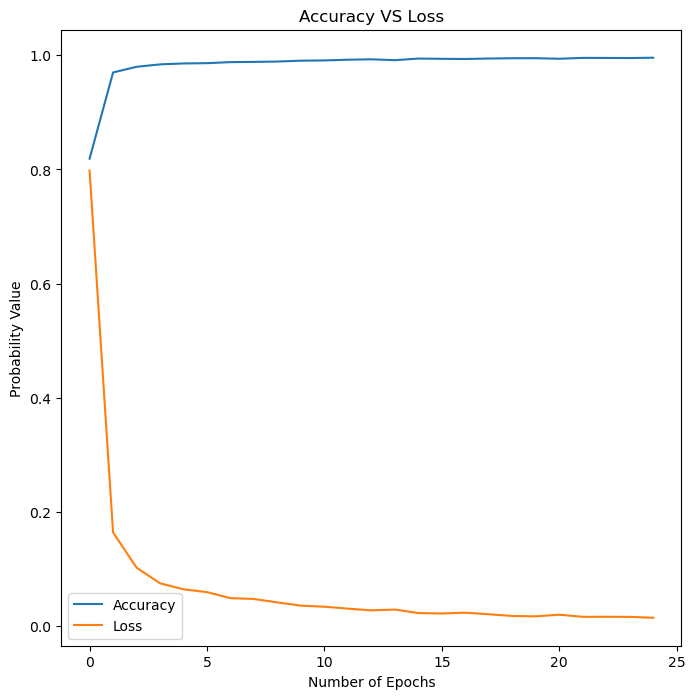

In [15]:
# Defining the size of the figure
plt.figure(figsize=(8,8))

# Labels
plt.xlabel('Number of Epochs')
plt.ylabel('Probability Value')

# Accuracy plot
plt.plot(history.history['accuracy'])

# Title
plt.title('Accuracy VS Loss')

# Loss plot
plt.plot(history.history['loss'])

# Making the legend
plt.legend(['Accuracy', 'Loss'])

# Displaying the entire plot
plt.show()

## Summary of the above plot
* Around epochs 4 there is huge change of loss and accuracy.
* After 5th epochs the accuracy and loss are likely to have a less diversion.

### **Predicting**

In [16]:
# predicting the model with test dataset

test_pred=model.predict(test_dataset)

113/113 [==============================] - 17s 146ms/step


In [17]:
# getting the index of the highest value

test_df["predict"]=np.argmax(test_pred,axis=1)

In [18]:
# Assigning the class names for the keys in predict column of the test_df

test_df["predict_c"]=test_df["predict"].map({0 : '0',
 1 : '1',
 2 : '2',
 3 : '3',
 4 : '4',
 5 : '5',
 6 : '6',
 7 : '7',
 8 : '8',
 9 : '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z'})

In [19]:
# dispaying the dataframe

test_df

,filename,category,predict,predict_c
32575,W/616.jpg,W,32,W
35860,Z/873.jpg,Z,35,Z
18152,I/235.jpg,I,18,I
19531,J/577.jpg,J,19,J
23472,N/523.jpg,N,23,N
...,...,...,...,...
19902,J/910.jpg,J,19,J
21086,L/176.jpg,L,21,L
19327,J/393.jpg,J,19,J
2881,2/892.jpg,2,2,2


In [20]:
# Returns the number of data in each category, the predicted count

test_df['category'].value_counts()

W    100
Z    100
E    100
5    100
R    100
0    100
2    100
K    100
G    100
F    100
L    100
8    100
A    100
D    100
U    100
V    100
4    100
T    100
9    100
O    100
C    100
I    100
J    100
N    100
7    100
Y    100
1    100
P    100
H    100
S    100
6    100
B    100
Q    100
3    100
X    100
M    100
Name: category, dtype: int64

In [21]:
# Returns the number of data in each category, the actual count

test_df['predict_c'].value_counts()

E    101
R    101
7    101
6    101
W    100
G    100
0    100
2    100
K    100
F    100
Z    100
L    100
8    100
A    100
D    100
U    100
V    100
T    100
9    100
O    100
S    100
I    100
Y    100
1    100
C    100
H    100
P    100
B    100
Q    100
3    100
X    100
M    100
N     99
J     99
5     99
4     99
Name: predict_c, dtype: int64

In [22]:
# getting the classification report for the test data

print(classification_report(y_pred=test_df['predict_c'], y_true=test_df['category']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      0.99      0.99       100
           5       1.00      0.99      0.99       100
           6       0.99      1.00      1.00       100
           7       0.99      1.00      1.00       100
           8       1.00      1.00      1.00       100
           9       1.00      1.00      1.00       100
           A       1.00      1.00      1.00       100
           B       1.00      1.00      1.00       100
           C       1.00      1.00      1.00       100
           D       1.00      1.00      1.00       100
           E       0.99      1.00      1.00       100
           F       1.00      1.00      1.00       100
           G       1.00      1.00      1.00       100
           H       1.00    

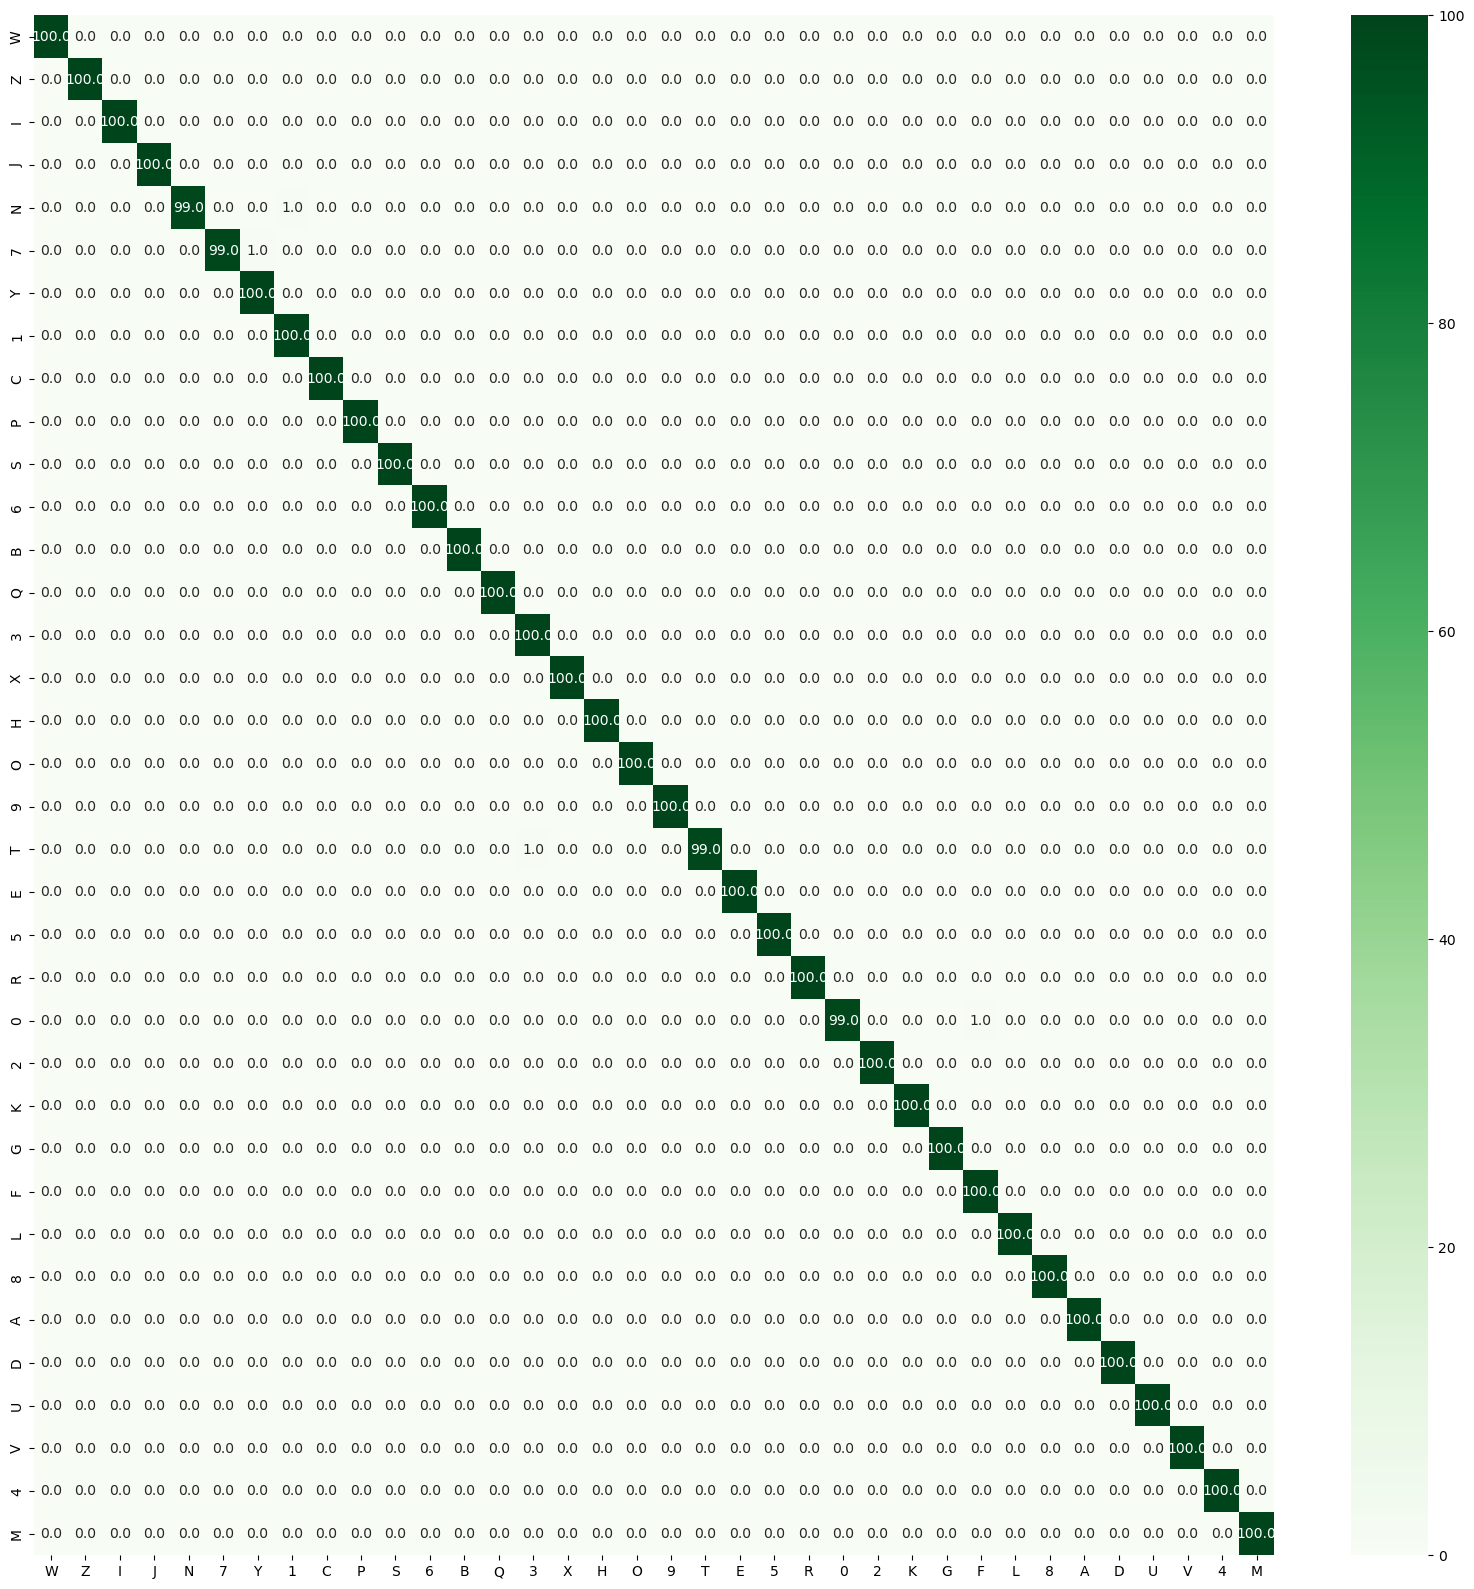

In [23]:
# confusion matrix for test data

plt.figure(figsize=(20,20))
sns.heatmap(confusion_matrix(y_pred=test_df['predict_c'], y_true=test_df['category']), annot=True,
            xticklabels=test_df['category'].unique(), yticklabels=test_df['category'].unique(), fmt='.1f', cmap='Greens')
plt.show()

In [24]:
# saving the model locally

model.save("ISL-alpha-numeric.h5")
print("Saved model to disk")

Saved model to disk


# Summary
* The model gives **100% accuracy and 100% precision** in the **test data.** Where the **classes 6, 7, E, R** has a **precision of 99%**
* This Xception model with 3 layers of ANN or the fully connected layers results in best classification with a learning rate of 0.0001
* The model was saved to the local system which sized around 849 MB.

#